In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz
from utils import sample_PLN
import scipy.linalg as SLA
import torch.linalg as TLA
import scipy
from fastPLN import fastPLN
from scipy.special import factorial
import math
import seaborn as sns 
import torch 
from pandas import read_csv
import math
import time
#torch.set_default_dtype(torch.float64)

device :  cpu


/home/bastien/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607369981906/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
%load_ext autoreload

%autoreload 2

$$
\begin{aligned}
W_{i} & \sim \mathcal{N}\left(0, I_{q}\right), \text { iid, } \quad i=1, \ldots, n \\
Z_{i} &=\mathbf{x}_{i}\beta +W_{i}\mathbf{C}^{\top}, \quad i \in 1, \ldots, n \\
Y_{i j} \mid Z_{i j} & \sim \mathcal{P}\left(\exp \left(o_{i j}+Z_{i j}\right)\right)
\end{aligned}
$$

We want to maximize the likelihood with respect to $\theta$ : 


$$\max _{\theta} P_{\theta}(Y)$$

But we need to integrate out $W$ in order to compute the quantity inside the max : 

$$
\begin{aligned}
P_{\theta}\left(Y_{i}\right) &=\int P_{\theta}\left(Y_{i}, W\right) d W \\
&=\int P_{\theta}\left(Y_{i} \mid W\right) p(W) d W
\end{aligned}
$$

This integral being untractable, we are going to approximate it with Monte Carlo methods : 

$$
\int p_{\theta}\left(Y_{i} \mid W\right) p(W) d W \approx \frac{1}{K} \sum_{k = 1 }^Kp_{\theta}\left(Y_{i} \mid W_{i,k}\right) p\left(W_{i,k}\right)
$$
$$W_{i,k} \sim \mathcal N (0, I_q)$$

The larger the $K$ the better the approximation.  

Let's compute $p_{\theta}\left(Y_{i} \mid W_{i,k}\right) p\left(W_{i,k}\right)$. 


First, 

$$
P\left(W_{i,k}\right)=\frac{1}{\sqrt{2 \pi}} \exp \left(-\frac{1}{2}\left\|W_{i,k}\right\|_{2}^{2}\right)
$$ 

Then, 

$$
\begin{aligned}
P_{\theta}\left(Y_{i} \mid W_{i,k}\right) &=\prod_{j=1}^{p} p_{\theta}\left(Y_{i j} \mid W_{i,k}\right) \\
&=\prod_{j=1}^{P} \frac{1}{Y_{i j} !} \exp \left(-\exp \left(o_{i j}+z_{i j}\right)\right) \exp \left(o_{i j}+z_{i j}\right)^{Y_{ij}}
\end{aligned}
$$
$$
Z_{i j}=x_{i}^{\top} \beta_{j}+W_{i,k}^{\top} C^{\top} _{j}
$$

For numerical purposes, we may want to use a logarithmic scale and apply the exponential function after. Indeed, $Y_{ij}$ can go up to a thousand, and computing this factorial would give infinite values. 

$$
\log p_{\theta}\left(Y_{i} \mid W_{i,k}\right)=\sum_{j=1}^{p} - \ln \left(Y_{i j} !\right)-\exp \left(0_{i j}+Z_{i j}\right)+Y_{i j}\left(o_{i j}+Z_{i j}\right)
$$

If we consider the whole likelihood : 

$$
\begin{aligned}
\ln p_{\theta}\left(Y \mid W_{k}\right) &=\sum_{i=1}^{n} \log p_{\theta}\left(Y_{i} \mid W_{i k}\right) \\
&=\sum_{i=1}^{n} \sum_{j} - \ln \left(Y_{ij} ! \right)-\exp \left(0_{i j}+Z_{i j}\right)+Y_{i j}\left(0_{i j}+Z_{i j}\right) \\
&=1_{n}^{T}\left[-\ln (Y !)-\exp (0+Z)+Y \odot (0+Z)\right] 1_{p} \\
Z=& X \beta+W_{k} C^{\top}
\end{aligned}
$$

We are going tu use the Stirling Formula in order to compute the log of the factorial, to avoid computing directly the factorial.  

We now need to compute the gradients. Since 

$$
\nabla_{\theta} p_{\theta}\left(Y_{i} \mid W_{i,k}\right)=p_{\theta}\left(Y_{i}| W_{i,k}\right) \nabla_{\theta} \log p_{\theta}\left(Y_{i} \mid W_{i,k}\right)
$$

We get : 

$$
\nabla_{\beta} p_{\theta}\left(Y_{i} \mid W_{i,k}\right)=p_{\theta}\left(Y_{i} \mid W_{i,k}\right)\left[-x_{i}^{\top} \exp \left(0_{i}+x_{i}^{\top} \beta+W_{i,k}^{\top} C^{\top}\right)+ x_{i}^{\top}Y_i\right]
$$
$$
\nabla_{C} p_{\theta}\left(Y_{i} \mid W_{i,k}\right)=p_{\theta}\left(Y_{i} \mid W_{i,k}\right)\left[-W_{i,k}^{\top} \exp \left(0_{i}+x_{i}^{\top} \beta+W_{i,k}^{\top} C^{\top}\right)+ W_{i,k}^{\top}Y_i\right]
$$
This is if we take only one sample $Y_i$. If we take the whole dataset (or a mini-batch), we get (writed in matrix form) :

$$
\nabla_{\beta} p_{\theta}\left(Y \mid W_k\right)=p_{\theta}\left(Y \mid W_k\right)\left[-X^{\top} \exp \left(0+X\beta+W_k^{\top} C^{\top}\right)+ X^{\top}Y\right]
$$

$$
\nabla_{C} p_{\theta}\left(Y \mid W_k\right)=p_{\theta}\left(Y \mid W_k\right)\left[Y-\exp \left(0+X \beta+W_k^{\top} C^{\top} \right)\right]
^{\top}W_k 
$$

After trying to optimize the likelihood, we have found that the likelihood is very small (the order of the log likelihood is about $1e^{-3}$ for some samples which makes the exponential 0 numerically. We can't optimize the log likelihood directly due to the integral : 


$$
\begin{aligned}
\log p_{\theta}(Y) &=\log \left(\int p_{\theta}(Y, W)dW\right) \\
& \approx \log \left(\frac{1}{K}\sum^K p_{\theta}\left(Y, W_{k}\right)\right)\\
& \neq \frac{1}{K} \sum^{K} \log \left(p_{\theta}\left(Y, W_{k}\right)\right)
\end{aligned}
$$

Indeed, we must compute the likelihood which results in numerical zero.

We thus change the objective function. We want to maximize the log likelihood with respect to $\theta$ : 


$$\max _{\theta}log P_{\theta}(Y)$$


(We tried to do a Monte Carlo to maximize the likelihood but it resulted in numerical 0). We need to derive the gradients with respect to theta : 


$$
\begin{aligned}
\nabla_{\theta} \log p_{\theta}(Y)&= \frac{\nabla_{\theta} p_{\theta}(Y)}{p_{\theta}(Y)} \\
&=\frac{\nabla_{\theta} \int p_{\theta}(Y \mid W) p(W) d W}{\int p_{\theta}(Y \mid W) p(W) d W}\\
&=\frac{\int \nabla_{\theta} p_{\theta}(Y | W) p(W) d W}{\int  p_{\theta}(Y|W) p(W) d w}\\
&= \frac{\int\left(\nabla_{\theta} \ln p_{\theta}(Y \mid W)\right) p_{\theta}(Y| W) p(W) d W}{\int p_{\theta}(Y \mid W)p(W) d W}\\
&=\int \nabla_{\theta} \ln p_{\theta}(Y \mid W) \tilde{p}_{\theta}(W) dW \\
\end{aligned}
$$
$$\tilde p_{\theta}(W):=\frac{p_{\theta}(Y \mid W) p(W) d W}{\int p_{\theta}(Y \mid W) p(W) dW}$$

We only know the numerator of $\tilde p_{\theta}(W)$. Thus we need to use importance sampling, which consits in the following : 

Let $g$ be a probability density such that $x \in \operatorname{supp}(\tilde p_{\theta}) \implies g(x)>0$. We denote $(V_i)_i \overset{iid}{\sim} g$. 

We define : 

$$
w_{k}^{(u)}=\frac{p_{\theta}\left(Y|V_k\right)p(V_k)}{g\left(V_{k}\right)}
$$


$$
\tilde{w}_{k}^{(u)}=\frac{w_{k}^{(u)}}{\sum_{\ell=1}^{n} w_{\ell}^{(u)}}
$$


Then, 

$$
\hat{I}_{n_{\text{samples}}}^{I S, u}:=\sum_{k=1}^{n_{\text{samples}}} \tilde{w}_{k}^{(u)} \nabla_{\theta} \ln p_{\theta}(Y \mid V_k)
 \stackrel{\text { Proba }}{\longrightarrow} \nabla_{\theta} \log p_{\theta}(Y)
$$

We need to choose carefully the density $g$ i.e. where $\tilde p_{\theta}\times \nabla_{\theta} \log p_{\theta}$ has a lot of mass. We can see that : 

$$\tilde p_{\theta}(W):=\frac{p_{\theta}(Y \mid W) p(W) d W}{\int p_{\theta}(Y \mid W) p(W) dW}=\frac{p_{\theta}\left(W|Y) P_{\theta}(Y)\right.}{\int p_{\theta}(W \mid Y) p_{\theta}(Y) d W}=\frac{p_{\theta}(W \mid Y)}{\int p_{\theta}(W | Y) dW }$$

Since $W|Y$ can be well-approximated with a Gaussian, this suggests to choose a Gaussian for $g$. We need to find the mean and the variance. Let's look at the density : 


$$
\begin{aligned}
p_{\theta}(W \mid Y_i) &=\frac{p_{\theta}(Y_i|W) \operatorname{p}(W)}{p_{\theta}(Y_i)} \\
& = C \times  {p_{\theta}}\left(W \mid Y_{i}\right)p(W)
\end{aligned}
$$

If we apply the log: 

$$
\log p_{\theta}\left(W \mid Y_{i}\right)=C+\log p_{\theta}\left(Y_{i} \mid W\right) \beta+\log p_{\theta}(W)
$$


$$
=C+\sum_{j}-\exp \left(O_{i j}+Z_{i j}\right)+Y_{i j}\left(O_{ij} +Z_{i j}\right)
$$
$$Z_{i j}:=X_{i}^{\top} \beta_{j}+W^{\top}C_{j}$$
We only know the density, and we want to fine the better Gaussian approximation. We first focus on the mean. We do as if $W|Y$ is  Gaussian. The mean  of a $\mathcal N(\mu,\Sigma)$ is characterized as : 

$$\mu = \operatorname{argmax}_x \mathcal logN(x;\mu,I)$$

We thus look for 


$$\widehat \mu_i  = \operatorname{argmax}_W =\log p_{\theta}\left(W \mid Y_{i}\right)$$


sizes : 

$ Y : (n,p)$ 

$O : (n,p)$ 

$C :  (p,q)$ 

covariates ($x$) : $(n,d)$

$\beta : (d,p)$

In [54]:
def build_block_Sigma(p,k): 
    '''
    build a matrix per block of size (p,p). There will be k+1 blocks of size p//k.
    The first k ones will be the same size. The last one will be smaller (size (0,0) if k%p = 0)
    '''
    np.random.seed(0)
    alea = np.random.randn(k+1)**2+1# will multiply each block by some random quantities 
    Sigma = np.zeros((p,p))
    block_size,last_block_size = p//k, p%k
    for i in range(k): 
        Sigma[i*block_size : (i+1)*block_size ,i*block_size : (i+1)*block_size] = alea[i]*toeplitz(0.95**np.arange(block_size))
    if last_block_size >0 :
        Sigma[-last_block_size:,-last_block_size:] = alea[k]*toeplitz(0.98**np.arange(last_block_size))
    return Sigma+0.1*toeplitz(0.95**np.arange(p))


def C_from_Sigma(Sigma,q): 
    ''' 
    get the best matrix of size (p,q) when Sigma is of size (p,p). i.e. reduces norm(Sigma-C@C.T)
    args : 
        Sigma : np.array of size (p,p). Should be positive definite and symmetric.
        q : int. The number of columns you want in your matrix C. 
        
    returns : C_reduct : np.array of size (p,q) that contains the q eigenvectors with largest eigenvalues. 
    '''
    w,v = SLA.eigh(Sigma)
    C_reduct = v[:,-q:]@np.diag(np.sqrt(w[-q:]))
    return C_reduct

def check_grad(my_grad_C, true_grad_C, my_grad_beta, true_grad_beta): 
    'simple function to check if the gradients computed by ourselves are the same as the one from pytorch'
    diff_C = torch.norm(my_grad_C-true_grad_C)
    diff_beta = torch.norm(my_grad_beta-true_grad_beta)
    print('diff_C : ', diff_C)
    print('my_grad_C : ', my_grad_C)
    print('true__grad_C : ', true_grad_C)
    print('diff_beta : ', diff_beta)
    print('my_grad_beta : ', my_grad_beta)
    print('true_grad_beta : ', true_grad_beta)

In [55]:
def compare_models(dict_models,name_doss, save = False):
    '''
    function to compare models. It will plot the MSE of Sigma and beta according to the true parameters and 
    the log_likelihood in the y axis with the runtime in the x-axis.
    
    args : 
        'dict_models' dict with key the name of the model and values the model (MC_PLNPCA object where you
                      have called model.fit_IMPS()).
        'name_doss' : str. the name of the file you want to save the graphic. 
        'save' : bool. If True, the graphic will be saved. If false, won't be saved. 
        
    returns : 
            None but displays the figure. you can save the figure if you uncomment the last line. 
    '''
    
    fig,ax = plt.subplots(3,1,figsize = (15,15))
    
    for name,model in dict_models.items() : 
        
        d = model.beta.shape[0]

        abscisse = model.running_times
        plt.subplots_adjust(hspace = 0.4)
        ax[0].plot(abscisse, model.MSE_Sigma_list, label = name)
        ax[0].legend()
        ax[0].set_title('MSE Sigma')
        #ax[0].set_xlabel('Seconds')
        ax[0].set_ylabel('MSE')
        ax[0].set_yscale('log')
        #ax[0].set_yticks()
        
        ax[1].plot(abscisse, model.MSE_beta_list, label = name)
        ax[1].legend()
        ax[1].set_title('MSE beta') 
        #ax[1].set_xlabel('Seconds')
        ax[1].set_ylabel('MSE')
        ax[1].set_yscale('log')
        
        
        ax[2].plot(abscisse, model.log_likelihood_list, label = name )
        ax[2].legend()
        ax[2].set_title('log_likelihood')
        ax[2].set_ylabel('log_likelihood')
        #ax[2].set_xlabel('Seconds')

    if save : 
        plt.savefig(name_doss)
    plt.show()
    
    
def show(model,name_doss , save = False):
    '''
    function to show one model. It will plot the MSE of Sigma and beta according to the true parameters and 
    the log_likelihood in the y axis with the runtime in the x-axis.
    
    args : 
        'model' MC_PLNPCA object where you have called model.fit_IMPS()
        'name_doss' : str. the name of the file you want to save the graphic. 
        'save' : bool. If True, the graphic will be saved. If false, won't be saved. 
        
    returns : 
            None but displays the figure. you can save the figure if you uncomment the last line. 
    '''
    
    fig,ax = plt.subplots(4,1,figsize = (15,15))
    
        
    d = model.beta.shape[0]

    abscisse = model.running_times
    plt.subplots_adjust(hspace = 0.4)
    ax[0].plot(abscisse, model.MSE_Sigma_list)
    ax[0].set_title('MSE Sigma')
    #ax[0].set_xlabel('Seconds')
    ax[0].set_ylabel('MSE')
    ax[0].set_yscale('log')

    ax[1].plot(abscisse, model.MSE_beta_list)
    ax[1].set_title('MSE beta') 
    #ax[1].set_xlabel('Seconds')
    ax[1].set_ylabel('MSE')
    ax[1].set_yscale('log')

    length = len(abscisse)
    ax[2].plot(abscisse, model.log_likelihood_list)
    ax[2].set_title('log_likelihood')
    ax[2].set_ylabel('log_likelihood')
    #ax[2].set_xlabel('Seconds')


    ax[3].plot(abscisse, model.norm_grad_log_C_list, label = 'norm grad loglike C')
    ax[3].plot(abscisse, model.norm_grad_log_beta_list, label = 'norm grad loglike beta')
    ax[3].set_title('Norm Gradients loglike ')
    ax[3].set_ylabel('L1 norm')
    ax[3].set_yscale('log')
    ax[3].legend()
    #if you want more, but useless most of the time. 
    '''
    ax[5].plot(abscisse, model.norm_grad_log_beta_list, label = name)
    ax[5].legend()
    ax[5].set_title('Gradient norm wrt beta of the loglikelihood given W')
    #ax[5].set_xlabel('Seconds')
    ax[5].set_ylabel('L1 norm') 
    ax[5].set_yscale('log')

    ax[6].plot(abscisse, model.norm_grad_log_C_list, label = name)
    ax[6].legend()
    ax[6].set_title('Gradient norm wrt C of the loglikelihood given W')
    ax[6].set_xlabel('Seconds')
    ax[6].set_ylabel('L1 norm') 
    #ax[6].set_yscale('log')
    '''
    if save : 
        plt.savefig(name_doss)
    plt.show()

In [10]:
def log_stirling(n_):
    '''
    this function computes log(n!) even for n large. We use the Stirling formula to avoid 
    numerical infinite values of n!. It can also take tensors.
    
    args : 
         n_ : tensor. 
    return : an approximation of log(n!)
    '''
    n = torch.clone(n_) #clone the tensor by precaution
    n+= (n==0) # replace the 0 with 1. It changes anything since 0! = 1! 
    return torch.log(torch.sqrt(2*np.pi*n))+n*torch.log(n/math.exp(1)) #Stirling formula

In [88]:
class MC_PLNPCA(): 
    
    def __init__(self,q, batch_size, sigma = 0.4): 
        self.q = q
        self.batch_size = batch_size 
        self.sigma = sigma
        self.running_times = list()
        self.norm_grad_C_list = list()
        self.norm_grad_beta_list = list()
        self.norm_grad_log_C_list = list()
        self.norm_grad_log_beta_list = list()
        self.MSE_Sigma_list = list()
        self.MSE_beta_list = list()
        self.log_likelihood_list = list() 
        self.gaussian_list= list()
    
    def init_data(self, Y,O,covariates): 
        '''
        Initialise some usefuls variables given the data. 
        We also initialise C and beta. 
        '''
        #torch.manual_seed(0)
        self.Y = Y 
        self.covariates = covariates 
        self.O = O 
        self.n = Y.shape[0] 
        self.p = Y.shape[1]
        self.d = self.covariates.shape[1]
        noise = torch.randn(self.p) 
        self.Sigma =  (torch.diag(noise**2)+ 1e-1)
        
        # init C with an array of size (p,q)
        self.C = torch.clone(torch.from_numpy(C_from_Sigma(self.Sigma,self.q)))
        
        #self.C = torch.clone(true_C)
        
        self.C.requires_grad_(True)
        self.beta = torch.randn(self.d,self.p)
        
        #self.beta = torch.clone(true_beta)
        
        self.beta.requires_grad_(True)
        
        self.gaussian_mean = torch.empty(self.n,self.q)
        
        
    def get_Sigma(self):
        '''
        simple function to get Sigma. We do this since we only optimize C. 
        '''
        return self.C@(self.C.T)

    def get_batch(self,batch_size, save_batch_size = True): 
        '''
        get the batches required to do a  minibatch gradient ascent.  
        
        args : 
                'batch_size' int.  the batch size you want. 
                
        returns : a generator. Will generate n/batch_size samples of size batch_size (except the last one 
                    since the rest of the division is not always 0)
        '''
        #np.random.seed(0)
        indices = np.arange(self.n)
        np.random.shuffle(indices)
        #if we want to set the batch size of the model to the given batch_size 
        if save_batch_size : 
            self.batch_size = batch_size
        # get the number of batches and the size of the last one. 
        nb_full_batch, last_batch_size  = self.n//self.batch_size, self.n % self.batch_size  
        for i in range(nb_full_batch): 
            yield   (self.Y[indices[i*self.batch_size: (i+1)*self.batch_size]], 
                    self.covariates[indices[i*self.batch_size: (i+1)*self.batch_size]],
                    self.O[indices[i*self.batch_size: (i+1)*self.batch_size]], 
                    ) 
        if last_batch_size != 0 : 
            self.batch_size = last_batch_size
            yield   (self.Y[indices[-last_batch_size:]], 
                    self.covariates[indices[-last_batch_size:]],
                    self.O[indices[-last_batch_size:]]
                    )
         
    def get_mean_log_likelihood(self):
        '''
        get the mean of the likelihood of the model. We do this since it is very volatile.
        We need to have called the .fit_IMPS() method. 
        '''
        length = len(self.likelihood_list)
        #we take the last values to have a good approximation but we don't want to take too many values
        #since otherwise it will be biased ( the first values are smaller than the last one). 
        return torch.mean(torch.tensor([x  for x in self.log_likelihood_list[length//10:] if np.isnan(x) == False]))
    
    
    def compute_mean_log_likelihood(self, acc): 
        '''
        computes the mean of the log_likelihood of the whole dataset. Since we can only estimate
        the likelihood of some samples, we estimate the likelihood of each sample ( n samples in total),
        We take the log and then sum each logs. Since some likelihood results in numerical zero, 
        We take the mean of the samples that have non zero likelihood. 
        
        args : 
                acc : float lower than 1 and positive. The accuracy you want. We will sample 1/acc samples.
                
        returns : 
                the mean of the loglikelihood of each sample. 
        '''
        log_likelihood = 0
        N_samples = int(1/acc)
        compteur = 0 # here to compute the number of samples that the likelihood is not a numerical zero. 
        tmp_batch = 1 # batch_size of 1
        for Y_b, covariates_b, O_b in self.get_batch(tmp_batch, save_batch_size = False): 
            W = torch.randn(N_samples, tmp_batch, self.q)
            batch_like = self.batch_likelihood(Y_b,covariates_b,O_b,W) # batch_likelihood of one batch. 
            #if not Nan, we add the log of the likelihood. 
            if torch.isnan(batch_like).item() == False : 
                log_likelihood +=  torch.log(batch_like)
                compteur += tmp_batch
        #print('percentage taken : ', str(compteur/self.n*100) +'%')
        self.log_likelihood_list.append(log_likelihood/compteur)
        return log_likelihood/compteur 
                

        

    def log_P_WYgivenY(self,Y_i,covariates_i, O_i, W):
        '''
        computes the log of the density of (W,Y_i) given Y_i. It should look like a gaussian. 
        args : 
            Y_i : tensor of size p 
            covariates_i : tensor of size d 
            O_i : tensor of size p 
            W : torch of size q. should be a gaussian. 
            
        return : the log of the probability of (W,Y_i) given Y_i. 
        '''
        
        A_i = O_i + W.reshape(1,-1)@(self.C.T) +covariates_i@self.beta # temporary variable, for a clearer code. 
        return -1/2*torch.norm(W)**2 + torch.sum(-torch.exp(A_i)+W.reshape(1,-1)@(self.C.T)*Y_i)

    def each_log_P_WYgivenY(self,Y_b,covariates_b,O_b,W): 
        '''       
        
        computes the log of the density of (W,Y_b) given Y_b. Y_b is a tensor of size (n_batch,p).
        args : 
            Y_b : tensor of size (n_batch,p) 
            covariates_b : tensor of size (n_batch,d) 
            O_b : tensor of size (n_batch,p) 
            W : torch of size (n_batch,q). should be a gaussian. 
            
        returns : the log of the density of (W,Y_b) given Y_b
        '''
        A_b = O_b + W@(self.C.T) +covariates_b@self.beta # temporary variable, for a clearer code. 
        return -1/2*torch.norm(W,dim = 1)**2+torch.sum(-torch.exp(A_b)+W@(self.C.T)*Y_b, axis = 1) # we sum over n_batch
    def find_each_mean(self,Y_b,covariates_b, O_b, lr = 0.5, N_iter_max = 100,class_optimizer = torch.optim.Rprop):
        '''
        method to compute the mean of the best gaussian approximation of W|Y_b. We will compute n_batch * q 
        approximation. 
        
        args : 
            Y_b : tensor of size (n_batch,p) 
            covariates_b : tensor of size (n_batch,d) 
            O_b : tensor of size (n_batch,p) 
            lr : float. positive. the learning rate of the optimizer
            N_iter_max : the number of iteration you want to do. 
            class_optimizer : torch.optim.optimizer object.  the class of the optimizer. should be like 
                              torch.optim.Rprop. 
        returns : 
                W : the parameter that maximizes the log of the probability of P_WY given Y.
        '''
        W = torch.randn(self.batch_size,self.q) # here only to evaluate a function, we won't use it to 
                                                # approximate some function. 
        W.requires_grad_(True)
        optimizer = class_optimizer([W], lr = lr)
        i = 0
        while i < N_iter_max:  #and delta > tol :
            loss = -self.each_log_P_WYgivenY(Y_b,covariates_b, O_b, W) #compute the loss 
            loss.mean().backward()#We take the mean since we have a loss of (n_batch,q) dimensions. 
            optimizer.step()
            i+=1
            optimizer.zero_grad()
            if torch.isnan(loss).any() : 
                print('NANloss, find_each_mean funct : ', loss)
        return W 
    
    def get_conditional_density_j(self, j,Y_i,covariates_i, O_i,best_mean,  N_points): 
        '''
        get the conditional density on the dimension j (i.e. the density of W_j|(Y_i,W_-j) ). We will return 
        a list of some points of the density to plot it. 
        
        
        args : 
            Y_i : tensor of size p 
            covariates_i : tensor of size d 
            O_i : tensor of size p 
            best_mean : tensosr of size q. The mean of the best gaussian approximation you found. 
            N_points : int. The number of points you want in your plot. 100 is a good choice in general. 
        returns : 
            abscisse : a list that discretize the space of interest. i.e. a discretazion of 
            [best_mean[j]-3, best_mean[j]+3]
            density : the value of P_WYgivenY along the abscisse, for W_-j fixed and W_j is moving along the  abscisse. 
        '''
        #We get a mask so that we can fixed the values of best_mean except the j-th coordinate. We will move 
        # the j-th coordinate along the abscisse. 
        mask = torch.zeros(best_mean.shape[0], dtype = torch.bool)
        mask[j]= True
        #get the abscisse. for the abscisse, the space of interest is around best_mean[j] since 
        #W_j|Y_i,W_-j is roughly a gaussian centered in best_mean[j]
        abscisse = np.linspace(best_mean[j].detach().numpy()-3,best_mean[j].detach().numpy()+3,N_points)
        list_density = np.array([self.log_P_WYgivenY(Y_i,covariates_i,O_i,
                        best_mean.masked_scatter(mask,torch.Tensor([w]))).detach().numpy()
                                for w in abscisse])
        list_density-= np.max(list_density)# we remove the max to avoid nan Values when we take the exponential 

        density = np.exp(list_density)# we had the log so we need to take the exp now 
        
        return abscisse,density
    
    
    def plot_conditional(self,Y_b, covariates_b, O_b,gaussian_mean_b, N_points = 100):
        '''
        plot the density of the conditional densities W_j|Y_i,W_-j for i in range(self.batch_size) 
        and j in range(q)
        Thus, the figure  will contain n_batch*q plot. 
        
        args : 
            Y_b : tensor of size (n_batch,p) 
            covariates_b : tensor of size (n_batch,d) 
            O_b : tensor of size (n_batch,p) 
            gaussian_mean_b : tensor of size (n_batch,q) that contains the mean of the best gaussian
            approximation 
            N_points : the number of points you want in your plot. The larger the smoother the curve. 
            
        returns : None, but display the figure
        '''
        
        fig = plt.figure(figsize = (20,10))
        axes = fig.subplots(gaussian_mean_b.shape[0], gaussian_mean_b.shape[1])
        for i, (Y_i,covariates_i, O_i, gaussian_mean_i) in enumerate(zip(Y_b, covariates_b, O_b,gaussian_mean_b)): 
            for j in range(gaussian_mean_b.shape[1]): 
                abscisse, density = self.get_conditional_density_j(j,Y_i,covariates_i, O_i, gaussian_mean_i, N_points)
                true_max = abscisse[np.argmax(density)]# get the true max to plot it. 
                
                #normal_density = np.exp(np.array([-1/(2*self.sigma**2)*(w-gaussian_mean_b[i,j])**2 for w in abscisse])) 
                try : 
                    #density of a gaussian centered in gaussian_mean_b[i,j] to see the approximation
                    normal_density = np.exp(np.array([-1/(2*self.sigma**2)*(w-gaussian_mean_b[i,j].item())**2 for w in abscisse])) 
                    normal_density*= np.max(density)/np.max(normal_density)# We renormalize by some constants to plot similar things. 
                    axes[i,j].plot(abscisse, density, label = 'W|Y density')
                    axes[i,j].plot(abscisse, normal_density, label = 'Gaussian density')
                    axes[i,j].axvline(gaussian_mean_b[i,j], c = 'green', label = 'maximum found') # the max we found
                    axes[i,j].axvline(true_max, c = 'black', label = 'true_max')# the true max. 
                except : 
                    pass
                
        # We display the labels above and once. 
        lines, labels = fig.axes[0].get_legend_handles_labels()
        fig.legend(lines, labels, loc = 'upper center')
        plt.show()
    
    def log_P_WgivenY(self,Y_i,covariates_i, O_i, V_i):
        '''
        computes the log of the density of (V_i|Y_i). Y_i is a tensor of size p.
        
        args : 
            Y_i : tensor of size p 
            covariates_i : tensor of size d 
            O_i : tensor of size p 
            V_i : tensor of size q. It should be a gaussian with mean the corresponding best_mean, i.e.
            best_mean_i
            
        returns : 
                the log of the density of (V_i|Y_i)
        '''
        A_i = O_i + W.reshape(1,-1)@(self.C.T) +covariates_i@self.beta # temporary variable
        return torch.sum(-torch.exp(A_i)+W.reshape(1,-1)@(self.C.T)*Y_i) # we missed some constant values
                                                                        # but we don't care since we want to 
                                                                        # compute the argmax. 
        
    def batch_grad_log_beta(self, Y_b,covariates_b, O_b, W):
        '''
        computes the gradient of the log of the density for a batch, with respect to beta. 
        
        args:
            Y_b : tensor of size (n_batch,p) 
            covariates_b : tensor of size (n_batch,d) 
            O_b : tensor of size (n_batch,p) 
            W : tensor of size (N_samples, n_batch, self.q). Should be a gaussian. 
            
        returns : 
            the gradient of the log of the density. The formula is above. 
        '''
        #we do not sum up since we will need to multiply each quantity with a Monte Carlo approximation
        Z_b = O_b + covariates_b@self.beta + W@(self.C.T)
        return  (covariates_b.unsqueeze(2).T@(-torch.exp(Z_b)+Y_b)) # unsqueeze is here so that the transpose
                                                                    #makes sense
    
    def grad_log_beta(self, Y_i, covariates_i, O_i, V_k): 
        '''
        same as batch_grad_log_beta but for only one sample Y_i, covariates_i and O_i. 
        '''
        Z_i = O_i + covariates_i@self.beta + V_k@(self.C.T)
        return covariates_i.unsqueeze(1)@((-torch.exp(Z_i)+Y_i).unsqueeze(0))
    
    def batch_grad_log_C(self, Y_b,covariates_b, O_b, W):
        '''
        same as batch_grad_log_beta but the gradients is taken with respect to C.
        '''
        #we do not sum up since we will need to multiply each quantity with a Monte Carlo approximation
        Z_b = O_b + covariates_b@self.beta + W@(self.C.T)
        return ((-torch.exp(Z_b)+Y_b).permute(0,2,1)@W)
    
    def grad_log_C(self, Y_i, covariates_i, O_i, V_k): 
        '''
        same as grad_log_beta but the gradient is taken with respect  to C. 
        '''
        Z_i = O_i + covariates_i@self.beta + V_k@(self.C.T)
        return ((-torch.exp(Z_i)+Y_i).unsqueeze(1))@V_k.unsqueeze(0)
        
    
    def each_log_P_WYgivenY(self,Y_b,covariates_b,O_b,W):
        '''
        get the log of the density of (W,Y)|Y. W is a tensor of size (n_batch, self.q)
        We don't do it for all the samples W but only once. (useless)
        
        args : 
            Y_b : tensor of size (n_batch,p) 
            covariates_b : tensor of size (n_batch,d) 
            O_b : tensor of size (n_batch,p) 
            W : tensor of size ( n_batch, self.q). Should be a gaussian. 
            
        '''
        A_b = O_b + W@(self.C.T) +covariates_b@self.beta # temporary variable
        return -1/2*torch.norm(W,dim = 1)**2+torch.sum(-torch.exp(A_b)+W@(self.C.T)*Y_b, axis = 1)
    
    def batch_log_P_WYgivenY(self,Y_b,covariates_b,O_b,V_b):
        '''
        same as each_log_P_WYgivenY but do it for W of size (n_samples, n_batch, self.q)
        
        args : 
            Y_b : tensor of size (n_batch,p) 
            covariates_b : tensor of size (n_batch,d) S
            O_b : tensor of size (n_batch,p) 
            V_b : tensor of size (N_samples, n_batch, self.q). Should be a gaussian. 
            
        returns : a tensor of size (N_samples, n_batch) that contains the log of the density of WYgivenY
                for each samples W_i of size (n_batch,self.q) and each (Y_i,covariates_i,0_i) in the batch.  
        '''
        A_b = O_b + V_b@(self.C.T) +covariates_b@self.beta # temporary variable
        return -1/2*torch.norm(V_b,dim = 2)**2+torch.sum(-torch.exp(A_b)+V_b@(self.C.T)*Y_b, axis = 2)
    def batch_log_g(self,V_b, gaussian_mean_b): 
        '''
        method that computes the log of the density of a gaussian of mean gaussian_mean_b and variance 
        self.sigma*I. 
        
        args : 
            V_b : tensor of size (n_samples, n_batch, self.q). 
            
        returns : 
            the log density for each self.q dimensional gaussian (i.e. a tensor of size (n_samples, n_batch))
        '''
        
        const = -1/2*math.log(2*math.pi)-self.q*math.log(self.sigma) # the constant on the gaussian   
        return const -1/(2*self.sigma**2)*torch.norm(V_b-gaussian_mean_b, dim = 2)**2
    
    
    
    def compute_batch_mean_log_likelihood(self, Y_b, covariates_b, O_b,gaussian_mean_b,i, acc): 
        '''
        computes the mean of the log likelihood for a batch. We compute the likelihood for each Y_i and then
        take the sum of each logs. Since it is possible that the likelihood is a numerical zero, we take 
        the mean only on those that are  non zero. 
        args : 
            Y_b : tensor of size (n_batch,p) 
            covariates_b : tensor of size (n_batch,d) S
            O_b : tensor of size (n_batch,p) 
            gaussian_mean_b : tensor of size (n_batch,q) that contains the mean of the best gaussian
            approximation. Is useless in most cases. It is only here to plot the conditional distribution 
                          if there is a bug (i.e. all the likelihood computed are zero)
            'i': int : just a number to keep trace of the one that failed if it failed. 
            acc : float lower than 1 and positive. The accuracy you want. We will sample 1/acc samples.
            
        returns : a float that contains the mean. 
        
        '''
        log_likelihood = 0
        N_samples = int(1/acc)
        compteur = 0 
        for i in range(self.batch_size): 
            W = torch.randn(N_samples, 1, self.q)
            batch_like = self.batch_likelihood(Y_b[i].reshape(1,-1),covariates_b[i].reshape(1,-1),O_b[i].reshape(1,-1),W,verbose = False)
            if torch.isnan(batch_like).item() == False : 
                log_likelihood +=  torch.log(batch_like)
                compteur += 1 
        #print('percentage taken : ', str(compteur/self.batch_size*100) + '%')
        # try except block to catch non wanted values ( compteur = 0) 
        try : 
            self.log_likelihood_list.append(log_likelihood.item()/compteur)
        except : 
            print('i : ', i )
            print('BADONE')
            self.plot_conditional(Y_b, covariates_b, O_b,gaussian_mean_b)
        return log_likelihood.item()/compteur 
    def batch_likelihood(self, Y_b,covariates_b, O_b, W, get_mean = True, verbose = False):
        '''
        computes the likelihood of one batch. if self.batch_size is too large, it will probably return a zero
        since we take the product of the likeliood of each Y_i in Y_b. Since we take the mean, we take the mean 
        only for the likelihood that are non zero. 
        
        args : 
            Y_b : tensor of size (n_batch,p) 
            covariates_b : tensor of size (n_batch,d) 
            O_b : tensor of size (n_batch,p) 
            W : torch of size (n_samples, n_batch,q). should be a gaussian. 
            get_mean : bool : if we want to take the mean at the end. It depends on what we want to do. 
            verbose : bool. If true, will plot some variables. 
            
        returns : the likelihood. if mean = True, a float. 
                else, a tensor of size n_samples (i.e. W.shape([0])) 
        '''
        # see formula above for more details. 
        norm_W = -1/2*torch.sum(torch.norm(W,dim = 2)**2, axis = 1) # the norm of W
        log_fact = -torch.sum(log_stirling(Y_b)) # the factorial term. 
        Z_b = covariates_b@self.beta + W@(self.C.T) # Z, latent variable
        exp_term = -torch.sum(torch.exp(O_b+Z_b),axis = (1,2)) # exponential term
        data_term = torch.sum(Y_b * (O_b + Z_b),axis = (1,2)) # term with the data counts Y 
        sum_of_logs = (norm_W +log_fact +exp_term+data_term) # sum of all the logs
        if verbose :
            print('norm_W : ', norm_W.numpy(),'\n')
            print('log_factoriel', log_fact.numpy(),'\n')
            print('cov : ', covariates_b)
            print('beta : ', self.beta)
            print('covbeta ; ', covariates_b@self.beta)
            print('C', self.C)
            print('Z_b : ', covariates_b@self.beta + W@(self.C.T), '\n')
            print('exp_Z_b,', torch.exp(Z_b))
            print('exp_term ', exp_term.detach().numpy())
            print('data ',data_term.detach().numpy(),'\n')
            print('somme_of_logs ( = norm_W +log_fact + exp_term + data) : ', sum_of_logs.detach().numpy(),'\n' )
            print('somme -max : ',(sum_of_logs-torch.max(sum_of_logs)).detach().numpy(),'\n' )
            print('result = exp(somme)  ', torch.exp(sum_of_logs).detach().numpy(),'\n')
        nb_nonzero =  torch.sum(torch.exp(sum_of_logs)>0) # get the number of non zero values
        if get_mean : 
            return torch.sum(torch.exp(sum_of_logs-0*torch.max(sum_of_logs)))/nb_nonzero # we get the mean
                                                                                        # on the non zero values
        else : 
            return torch.exp(sum_of_logs)
        
    def fit_IMPS(self,Y, O, covariates,  N_iter, acc,lr,class_optimizer = torch.optim.Rprop): 
        '''
        method that fit the parameters C and beta  of the model according to the data Y,O, covariates. 
        We maximize the log likelihood thanks to a gradient ascent. The gradients are computed thanks to 
        importance sampling. 
        
        args : 
                Y : the counts, should be int. tensor of size(n,p)
                O : the offsets : tensor of size (n,p)
                covariates : the covariates of the model. tensor of size(n,d)
                N_iter : int : the number of iteration you want to do. 
                acc : float : the accuracy you want when you compute the gradients and the likelihood. We will 
                sample 1/int samples.
                lr : float, positive. the learning rate of the optimizer for C and beta.
                class_optimizer : the optimizer you want, ex : torch.optim.Rprop. It should be a torch.optim object
        returns : 
                None, but the parameters C and beta are optimized. 
        '''
        self.t0= time.time()# to keep track of the time. 
        self.init_data(Y,O, covariates)# initialize the data. 
        optim = class_optimizer([self.beta,self.C], lr = lr) # optimizer on C and beta
        optim.zero_grad() # We do this since it is possible that beta and C have gradients. 
        N_samples = int(1/acc) # We will sample 1/acc gaussians
        for i in range(N_iter):
            #self.compute_mean_log_likelihood(acc)
            for i, (Y_b, covariates_b, O_b) in enumerate(self.get_batch(self.batch_size)):
                
                if i //10 == 0 : 
                    print('MSE Sigma ', torch.mean((self.get_Sigma()-true_Sigma)**2).item())
                    print('-------------MSE beta : ', torch.mean((self.beta-true_beta)**2).item())
                 # we find the best gaussian_mean for the approximation
                gaussian_mean_b =  self.find_each_mean(Y_b, covariates_b, O_b,N_iter_max = 100)
                if i == -1 : 
                    self.gaussian_list.append(gaussian_mean_b)
                    #self.plot_conditional(Y_b, covariates_b, O_b,gaussian_mean_b)
                #print('gaussian ' , gaussian_mean_b)
                self.compute_batch_mean_log_likelihood(Y_b, covariates_b, O_b,gaussian_mean_b,i,acc)
                # sample some gaussians with the mean of the best gaussian approximation we found
                V_b = torch.randn(N_samples,self.batch_size, self.q)*self.sigma+gaussian_mean_b
                
                weights =  self.get_batch_weights(Y_b, covariates_b, O_b,V_b, gaussian_mean_b) # weights
                
                normalized_weights = weights/torch.sum(weights, axis = 0)#normalization (see formula above)
                #print('weights',weights)
                #print('normalizaton', torch.sum(weights, axis = 0))
                #print('normalized_weights', normalized_weights)
                
                # gradients of the log likelihood 
                grad_C = self.batch_grad_log_C( Y_b,covariates_b, O_b, V_b)
                grad_beta = self.batch_grad_log_beta( Y_b,covariates_b, O_b, V_b)
                # We mulitplu this with the weights (see formula)
                grad_C = torch.multiply(grad_C.unsqueeze(1),normalized_weights.unsqueeze(2).unsqueeze(3))
                grad_beta = torch.multiply(grad_beta.unsqueeze(1),normalized_weights.unsqueeze(2).unsqueeze(3))
                # We sum over the batches and the samples (maybe take the mean along the batch axis or not)
                grad_C = torch.mean(torch.sum(grad_C, axis = (0)), axis = 0)
                grad_beta = torch.mean(torch.sum(grad_beta, axis = (0)), axis = 0)

                self.C.grad = -grad_C 
                self.beta.grad = -grad_beta
                #print('grad norm : ', torch.norm(self.beta.grad))
                # bug : need to fix this bug #SGD
                #self.compute_mean_log_likelihood(acc)
                # keep records 
                self.MSE_Sigma_list.append(torch.mean((self.get_Sigma()-true_Sigma)**2).item())
                self.MSE_beta_list.append(torch.mean((self.beta-true_beta)**2).item())
                self.norm_grad_log_beta_list.append(torch.norm(grad_beta).item())
                self.norm_grad_log_C_list.append(torch.norm(grad_C).item())
                self.running_times.append(time.time()-self.t0)
                optim.step()
                optim.zero_grad()
            print('-----------------------------------------------------------------------------')
            print('-----------------------------------------------------------------------------')
            print('-----------------------------------------------------------------------------')
            print('----------------------------------------------------------------------------------------------------------------------------------------NEWBATCH')
                
                
                
    def get_batch_weights(self, Y_b, covariates_b, O_b,V_b, gaussian_mean_b):
        '''
        function to get the weights (weights formula in the importance sampling)
        for one batch . We take the log and then the exponential to avoid Nan values. 
        args : 
            Y_b : tensor of size (n_batch,p) 
            covariates_b : tensor of size (n_batch,d) 
            O_b : tensor of size (n_batch,p) 
            V_b : torch of size (n_samples, n_batch,q). should be a gaussian. 
            gaussian_mean_b : tensor of size(n_batch,q). 
            
        return : the weights (formula above), of size (n_batch)
        '''
        # see formula above. 
        log_f = self.batch_log_P_WYgivenY(Y_b,covariates_b,O_b,V_b)
        log_g = self.batch_log_g(V_b,gaussian_mean_b)
        log_fminus_log_g = log_f -log_g 
        #print('logf-g ', log_fminus_log_g)
        #print('max : ', torch.max(log_fminus_log_g, axis = 0 )[0])
        #print('log_fmg -max', log_fminus_log_g- torch.max(log_fminus_log_g, axis = 0 )[0])
        return torch.exp(log_fminus_log_g - torch.max(log_fminus_log_g, axis = 0 )[0]) #C*f/g

In [93]:
d = 4 # nb of cavariates
n = 100;  p = 15
q = 8

In [94]:
torch.manual_seed(int(time.time()))
true_Sigma = torch.from_numpy(build_block_Sigma(p,p//3))
true_C = torch.from_numpy(C_from_Sigma(true_Sigma, q))
true_beta =torch.randn((d, p))/2

covariates = torch.randn((n,d))
O =  0.5+torch.zeros((n,p))
sample_model = sample_PLN()
Y_sampled, Z_sampled  = sample_model.sample(true_Sigma,true_beta, O, covariates)
Y_sampled = torch.from_numpy(Y_sampled)

In [95]:
torch.manual_seed(int(time.time()))
batch_size = 5
model = MC_PLNPCA(q,batch_size)
%time model.fit_IMPS(Y_sampled,O, covariates,N_iter =14, acc= 0.1,lr = 0.001, class_optimizer = torch.optim.Rprop)

MSE Sigma  2.523271546766969
-------------MSE beta :  0.8666172903057856
MSE Sigma  2.5237540057764263
-------------MSE beta :  0.8660182774764564
MSE Sigma  2.5243005259387914
-------------MSE beta :  0.8654203211812953
MSE Sigma  2.5242999893467717
-------------MSE beta :  0.8647907100511358
MSE Sigma  2.5244743554573232
-------------MSE beta :  0.8640225595389133
MSE Sigma  2.5243987326995705
-------------MSE beta :  0.8633982804040233
MSE Sigma  2.5243892920731894
-------------MSE beta :  0.862956810879844
MSE Sigma  2.5244122848513886
-------------MSE beta :  0.862352297816163
MSE Sigma  2.525353610909361
-------------MSE beta :  0.8619630429706471
MSE Sigma  2.5260220424070274
-------------MSE beta :  0.8615765361873585
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
------------------------------

MSE Sigma  2.4366770859801927
-------------MSE beta :  0.8254607726875871
MSE Sigma  2.436679639575136
-------------MSE beta :  0.8254596876942296
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------NEWBATCH
MSE Sigma  2.4366665583295615
-------------MSE beta :  0.825443534095533
MSE Sigma  2.4366686391904344
-------------MSE beta :  0.8254420926653161
MSE Sigma  2.4366707166996733
-------------MSE beta :  0.8254403892159952
MSE Sigma  2.43666072911285
-------------MSE beta :  0.8254386688838998
MSE Sigma  2.4366642082381738
-------------MSE beta :  0.8254368116730875
MSE Sigma  2.436665798225842
-------------MSE beta :  0.8254348351478533
MSE Sigma  2.4366678871349894
----

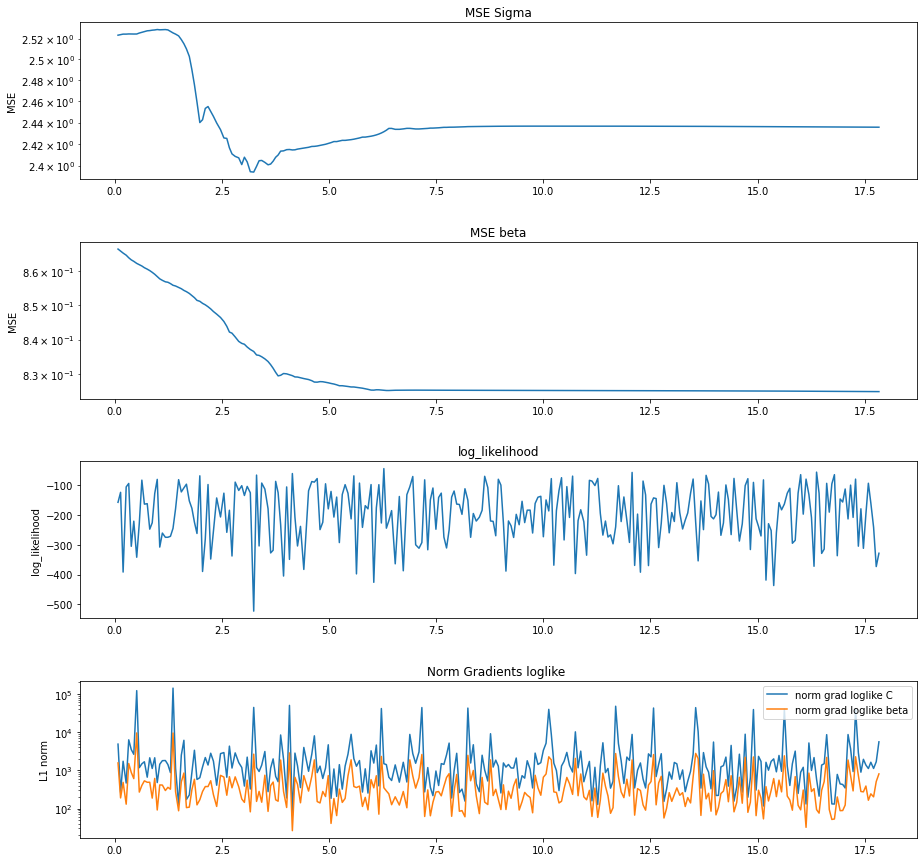

In [96]:
show(model,'')

In [196]:
model.gaussian_list

[tensor([[ 3.4413,  8.8770, -3.0749, -2.8010, -0.1365,  3.4125,  0.5551,  3.4234],
         [-0.1636,  0.4934, -1.5881,  2.4505, -0.4462, -0.3699,  0.8435, -1.8741],
         [-2.0942,  0.6389, -0.6651,  0.7224,  0.8642, -1.5410, -0.8376,  1.0249],
         [ 1.2659,  1.3578, -1.9764,  0.4024,  0.8523, -1.2282, -2.4443,  1.2160],
         [-0.8509, -6.1356,  0.9869, -2.9696, -1.8852, -2.7765,  0.3145, -0.3647]],
        requires_grad=True),
 tensor([[ 1.9280,  1.0411, -4.9027, -5.0830,  2.9082,  3.6814,  0.2418, -1.4030],
         [-0.7261,  2.5675, -1.2661,  2.5240, -0.0109,  0.0955,  1.1853,  0.3670],
         [-1.1495, -0.3693, -1.3130,  0.3985,  0.6960, -1.3957, -0.2753, -1.3808],
         [-0.0525,  1.4059, -1.1906, -0.0101,  1.0597, -1.9655, -2.1423, -0.9207],
         [ 3.5696, -2.7826,  2.0374,  2.1817, -5.2140,  2.0546, -4.3893,  1.2118]],
        requires_grad=True),
 tensor([[ 2.5301,  1.4089, -5.3892, -4.6552,  3.0086,  3.2018,  0.1817, -1.3443],
         [-0.6015,  2.4814,

In [77]:
Y_sampled

tensor([[ 0,  2,  1,  ...,  1,  0,  2],
        [ 1,  0,  0,  ...,  4, 86,  9],
        [ 2, 95, 51,  ...,  4,  5,  4],
        ...,
        [ 4,  3,  5,  ...,  0,  1,  1],
        [ 0,  1,  0,  ...,  1,  1,  4],
        [ 0,  0,  2,  ...,  2,  2,  0]])

$$
\nabla_{\beta} p_{\theta}\left(Y \mid W_k\right)=p_{\theta}\left(Y \mid W_k\right)\left[-X^{\top} \exp \left(0+X\beta+W_k^{\top} C^{\top}\right)+ X^{\top}Y\right]
$$

$$
\nabla_{C} p_{\theta}\left(Y \mid W_k\right)=p_{\theta}\left(Y \mid W_k\right)\left[Y-\exp \left(0+X \beta+W_k^{\top} C^{\top} \right)\right]
^{\top}W_k 
$$

$$
\begin{aligned}
P_{\theta}\left(Y_{i} \mid W_{i,k}\right) &=\prod_{j=1}^{p} p_{\theta}\left(Y_{i j} \mid W_{i,k}\right) \\
&=\prod_{j=1}^{P} \frac{1}{Y_{i j} !} \exp \left(-\exp \left(o_{i j}+z_{i j}\right)\right) \exp \left(o_{i j}+z_{i j}\right)^{Y_{ij}}
\end{aligned}
$$
$$
Z_{i j}=x_{i}^{\top} \beta_{j}+W_{i,k}^{\top} C^{\top} _{j}
$$




In [34]:
class MC_PLNPCA_bis(): 
    
    def __init__(self,q, batch_size): 
        self.q = q
        self.batch_size = batch_size 
        pass
    
    def init_data(self, Y,O,covariates): 
        '''
        Initialise some usefuls variables given the data. 
        We also initialise C and beta. 
        '''
        self.Y = Y 
        self.covariates = covariates 
        self.O = O 
        self.n = Y.shape[0] 
        self.p = Y.shape[1]
        self.d = self.covariates.shape[1]
        noise = torch.randn(self.p) 
        self.Sigma =  (torch.diag(noise**2)+ 1e-1)
        self.C = torch.clone(torch.from_numpy(C_from_Sigma(self.Sigma,self.q)))
        #self.C = torch.clone(true_C)
        self.C.requires_grad_(True)
        self.beta = torch.randn(self.d,self.p)
        #self.beta = torch.clone(true_beta)
        self.beta.requires_grad_(True)
        
        
    
    def single_likelihood_test(self,i,acc): 
        '''
        computes the likelihood of a single point. Useless since We can compute it efficiently
        with batch_likelihood(). This is more a beta version. 
        '''
        N_iter = int(1/acc)
        Y_i = self.Y[i,:]
        x_i = self.covariates[i,:]
        O_i = self.O[i,:]
        E = 0
        for _ in range(N_iter):
            W = torch.randn(self.q)
            log_fact = torch.sum(log_stirling(Y_i))
            norm_W = 1/2*torch.norm(W)**2
            poiss_like = - torch.sum(torch.exp(self.O[i,:]+self.beta.T@self.covariates[i,:]+ self.C@W)) 
            poiss_like += torch.sum((self.O[i,:]+self.beta.T@self.covariates[i,:]+ self.C@W)*self.Y[i,:])
            E+= torch.exp(-log_fact -norm_W + poiss_like)
        return E/N_iter 
    def get_Sigma(self):
        '''
        simple function to get Sigma
        '''
        return self.C@(self.C.T)
    
    def get_batch(self,batch_size): 
        '''
        get the batches required to do a  minibatch gradient ascent.  
        
        args : 
                'batch_size' int.  the batch size you want. 
                
        returns : a generator. Will generate n/batch_size samples of size batch_size (except the last one 
                    since the rest of the division is not always an integer)
                    
        '''
        np.random.seed(0)
        indices = np.arange(self.n)
        np.random.shuffle(indices)
        self.batch_size = batch_size 
        nb_full_batch, last_batch_size  = self.n//self.batch_size, self.n % self.batch_size  
        for i in range(nb_full_batch): 
            yield   (self.Y[indices[i*self.batch_size: (i+1)*self.batch_size]], 
                    self.covariates[indices[i*self.batch_size: (i+1)*self.batch_size]],
                    self.O[indices[i*self.batch_size: (i+1)*self.batch_size]]) 
                        
                  
        if last_batch_size != 0 : 
            self.batch_size = last_batch_size
            yield   (self.Y[indices[-last_batch_size:]], 
                    self.covariates[indices[-last_batch_size:]],
                    self.O[indices[-last_batch_size:]])
        
    def compute_likelihood(self, acc): 
        likelihood = 0
        N_samples = int(1/acc)
        W = torch.randn(N_samples, self.n, self.q)
        likelihood +=  self.batch_likelihood(self.Y,self.covariates, self.O,W)
        return likelihood/self.n
    
    
    
    
    def batch_grad_beta(self,Y_b,covariates_b, O_b,W): 
        grad = 0
        log_like = torch.sum(self.batch_likelihood(Y_b,covariates_b, O_b,W, somme = False), axis = 1)
        first_term = -torch.exp(O_b +covariates_b@self.beta + W@(self.C.T))
        second_term = Y_b
        grad =  torch.sum(torch.multiply(log_like.reshape(-1,1,1),((covariates_b.T)@(first_term + second_term))), axis = 0)
        # the for loop here does the same, just a sanity check
        '''
        grad = 0
        for k in range(N_samples): 
            log_like = self.batch_likelihood(Y_b,covariates_b, O_b,W[k])#/N_samples
            exp_term  = -torch.exp(O_b +covariates_b@self.beta + W[k]@(self.C.T))
            grad +=  log_like*(covariates_b.T)@(exp_term + Y_b)
        '''
        return grad/W.shape[0]
    
    
    def batch_grad_C(self,Y_b,covariates_b, O_b,W): 
        grad = 0 
        for k in range(W.shape[0]):
            log_like = self.batch_likelihood(Y_b,covariates_b, O_b,W[k], somme = True)
            exp_term  = -torch.exp(O_b +covariates_b@self.beta + W[k]@(self.C.T))
            grad +=  log_like*((exp_term + 0*Y_b).T@W[k])
        return grad/W.shape[0]
            

            
            
    def batch_likelihood(self,Y_batch,covariates_batch, O_batch, W, somme = True ): 
        '''
        computes the approximation of the likelihood of a batch. 
        
        args : 
                'Y_batch' : tensor of size(batch_size, p)
                'covariates_batch' : tensor of size(batch_size, d)
                'O_batch' : tensor of size(batch_size, p)
                'acc' : float. the accuracy you want. The lower the accuracy, the lower the algorithm. 
                        we will sampThe size of tensor a (1000) must match the size of tensor b (20) at non-singleton dimension 2les 1/acc times. 
        returns : 
                the approximation of the likelihood. 
        ''' 
    
        last_dim = len(W.shape)-1
        if last_dim >1 : 
            N_samples = W.shape[0] # number of samples of W 
        else : N_samples = 1
        #N_samples = W.shape[0]
        Z = covariates_batch@self.beta + W@(self.C.T)
        norm_W = TLA.norm(W, dim = last_dim)**2
        log_fact =  torch.sum(log_stirling(Y_batch), axis = 1) # the factorial term 
        poiss_like =  - torch.sum(torch.exp(O_batch+Z), axis = last_dim) # first term of the poisson likelihood
                                                                         #the normalising term with the exponential 
        poiss_like += torch.sum((O_batch+Z)*Y_batch, axis = last_dim)    # second term of the poisson likelihood
        
            
        if somme : 
            # If we want the true likelihood
            # We first take the exponential of the sum of the logs and then divide by the Number of samples we took.  
            return torch.sum(torch.exp(-log_fact -1/2*norm_W+poiss_like))/N_samples 
        #for some purposes, we may want only the exponential and not the sum
        else : return torch.exp(-log_fact -1/2*norm_W+poiss_like)/N_samples

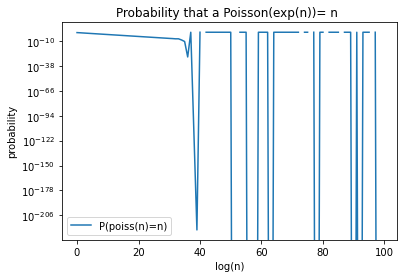

In [102]:
def proba_mean(mean_):
    mean = torch.Tensor([mean_])
    k = torch.Tensor([int(mean)])
    log_fact = -log_stirling(torch.Tensor([k]))
    exp_term = - mean
    data_term = k*torch.log(mean)
    somme = log_fact + exp_term + data_term 
    #print('somme ', somme)
    #print('result : ', torch.exp(somme))
    return torch.exp(somme)

for i in range(60): 
    pass
    #print('proab', proba_mean(np.exp(i)))

length = 100
prob = [proba_mean(np.exp(i)).numpy() for i in range(length)]

fig= plt.figure()
plt.plot(np.arange(length),prob, label = 'P(poiss(n)=n)')
plt.yscale('log')
plt.ylabel('probability')
plt.xlabel('log(n)')
plt.title('Probability that a Poisson(exp(n))= n ')
plt.legend()
#plt.savefig('poisson distribution')



In [65]:
def poiss_density(mean, k ): 
    return 1/factorial(k)*np.exp(-mean)*mean**k

#print([poiss_density(i,i) for i in range(70)])
    

[1.0, 0.36787944117144233, 0.2706705664732254, 0.22404180765538773, 0.19536681481316456, 0.17546736976785068, 0.16062314104798003, 0.1490027796743379, 0.13958653195059692, 0.1317556400095227, 0.1251100357211333, 0.1193780602280255, 0.11436791550944654, 0.10993981424841086, 0.10598914793051553, 0.10243586666453418, 0.09921753162215582, 0.09628462779844535, 0.09359731648870141, 0.09112313246841229, 0.08883531739208522, 0.08671159160336754, 0.0847332342752624, 0.08288438439146861, 0.0811515025272517, 0.07952295146806547, 0.07798866585178797, 0.07653988933052164, 0.07516896352687369, 0.07386915713933492, 0.07263452647159147, 0.07145980077773666, 0.07034028736850317, 0.06927179257562581, 0.06825055553466172, 0.06727319239963175, 0.06633664910130228, 0.06543816114459435, 0.06457521923824946, 0.06374553978250255, 0.06294703942359217, 0.062177813028978145, 0.061436114552760206, 0.06072034035351376, 0.06002901460152964, 0.05936077647306704, 0.058714368878625516, 0.058088628512689325, 0.05748247

In [50]:
'''
    def find_mean(self,Y_i,covariates_i, O_i, lr = 0.5, N_iter_max = 100, tol = 0.00001,class_optimizer = torch.optim.Rprop):
        W = torch.randn(self.q)
        W.requires_grad_(True)
        optim = class_optimizer([W], lr = lr)
        delta = tol +1
        old_loss = 0
        i = 0
        while i < N_iter_max:  #and delta > tol : 
            #print('i : ', i )
            optim.zero_grad()
            loss = -self.log_P_WYgivenY(Y_i,covariates_i, O_i, W)
            loss.backward()
            delta = abs(loss.item()-old_loss)
            old_loss = loss .item()
            #if i //20 == 0: 
            #    print('grad_norm : ', torch.norm(W.grad))
            #    print('likelihood : ', -loss)
            optim.step()
            i+=1
        return W 
        
        
    def fit(self, N_iter, acc): 
        optim_beta = torch.optim.Rprop([self.beta], lr = 0.3)
        optim_C = torch.optim.Rprop([self.C], lr = 0.3)
        N_samples = int(1/acc)
        for i in range(N_iter):
            for Y_b, covariates_b, O_b in self.get_batch(self.batch_size):
                W = torch.randn(N_samples,self.batch_size, self.q) 
                if False : 
                    optim_C.zero_grad()
                    #print('MSE Sigma: ', torch.mean((self.get_Sigma()-true_Sigma)**2).item())
                    grad_C = self.batch_grad_C(Y_b, covariates_b, O_b,W)
                    loss = -self.batch_likelihood(Y_b,covariates_b, O_b,W)
                    loss.backward()
                    #self.C.grad =  -grad_C/torch.norm(grad_C)
                    print('loss : ', loss.item())
                    optim_C.step()
                else : 
                    optim_beta.zero_grad()
                    print('MSE beta : ', torch.mean((self.beta-true_beta)**2).item())
                    grad_beta = self.batch_grad_beta(Y_b,covariates_b, O_b,W)
                    loss = -self.batch_likelihood(Y_b,covariates_b, O_b,W)
                    loss.backward()
                    self.beta.grad = -grad_beta/torch.mean(torch.abs(grad_beta))
                    optim_beta.step()
            print('----------------------------------------------------------------------new_epoch')


    def log_P_WYgivenY_dimj(self,Y_i,covariates_i, O_i, W,j):
        A_ij = O_i[j] + W.reshape(1,-1)@(self.C.T[:,j]) +covariates_i.reshape(1,-1)@(self.beta[:,j])
        return -1/2*torch.norm(W)**2 + torch.sum(-torch.exp(A_ij)+W.reshape(1,-1)@(self.C.T[:,j])*(Y_i[j]))
    
    
    def find_mean_j(self,Y_i,covariates_i, O_i,j, lr = 0.3, N_iter_max = 200, tol = 0.00001,class_optimizer = torch.optim.Rprop, verbose = False):
        W = torch.randn(1)
        W.requires_grad_(True)
        optim = class_optimizer([W], lr = lr)
        delta = tol +1
        old_loss = 0
        i = 0
        while i < N_iter_max:  #and delta > tol : 
            #print('i : ', i )
            optim.zero_grad()
            loss = -self.log_P_WYgivenY_dimj(Y_i,covariates_i, O_i, W,j)
            loss.backward()
            delta = abs(loss.item()-old_loss)
            old_loss = loss .item()
            if verbose : 
                if i //20 == 0: 
                    print('likelihood : ', -loss)
                    print('delta : ', delta)
                    print('grad_norm : ', torch.norm(W.grad))
                    print('likelihood : ', -loss)
            optim.step()
            i+=1
        return W.detach().numpy()

'''

1

In [ ]:
'''
    def likelihood_grad_batch_beta(self, Y_b,covariates_b, O_b, W):
        likelihood = self.batch_likelihood(Y_b,covariates_b, O_b, W, mean = False)
        Z_b = O_b + covariates_b@self.beta + W@(self.C.T)
        nb_non_zero = torch.sum(likelihood >0)
        grad_log = (covariates_b.unsqueeze(2).T@(-torch.exp(Z_b)+Y_b))
        if nb_non_zero > 0 : 
            self.norm_grad_log_beta_list.append(torch.mean(torch.abs(torch.sum(grad_log, axis = 0)/nb_non_zero)).item())
        
        return torch.sum(likelihood.reshape(-1,1,1)*grad_log, axis = 0)/nb_non_zero



    def likelihood_grad_batch_C(self, Y_b,covariates_b, O_b, W): 
        likelihood =  self.batch_likelihood(Y_b,covariates_b, O_b, W, mean = False)
        Z_b = O_b + covariates_b@self.beta + W@(self.C.T)
        grad_log = ((-torch.exp(Z_b)+Y_b).permute(0,2,1)@W)
        nb_non_zero = torch.sum(likelihood >0)
        #print('non_zero : ', nb_non_zero)
        if nb_non_zero > 0 : 
            self.norm_grad_log_C_list.append(torch.mean(torch.abs(torch.sum(grad_log, axis = 0)/nb_non_zero)).item())
            
        return torch.sum(likelihood.reshape(-1,1,1)*grad_log, axis = 0)/nb_non_zero 
'''